In [1]:
import tensorflow as tf
import keras
from keras import models, layers
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8953387937480378327
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3667263488
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18015121425106880027
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS=50

In [5]:
dataset = keras.utils.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256,256),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch)
    print(image_batch[0])
    print(label_batch)

tf.Tensor(
[[[[159. 153. 163.]
   [162. 156. 166.]
   [166. 160. 170.]
   ...
   [103.  96. 103.]
   [129. 122. 129.]
   [102.  95. 102.]]

  [[166. 160. 170.]
   [168. 162. 172.]
   [171. 165. 175.]
   ...
   [132. 125. 132.]
   [127. 120. 127.]
   [144. 137. 144.]]

  [[167. 161. 171.]
   [169. 163. 173.]
   [171. 165. 175.]
   ...
   [106.  99. 106.]
   [110. 103. 110.]
   [130. 123. 130.]]

  ...

  [[164. 157. 164.]
   [164. 157. 164.]
   [164. 157. 164.]
   ...
   [ 98.  88.  96.]
   [104.  94. 102.]
   [103.  93. 101.]]

  [[163. 156. 163.]
   [163. 156. 163.]
   [164. 157. 164.]
   ...
   [ 87.  77.  85.]
   [ 79.  69.  77.]
   [ 88.  78.  86.]]

  [[162. 155. 162.]
   [163. 156. 163.]
   [164. 157. 164.]
   ...
   [107.  97. 105.]
   [ 99.  89.  97.]
   [103.  93. 101.]]]


 [[[147. 145. 156.]
   [146. 144. 155.]
   [147. 145. 156.]
   ...
   [169. 171. 183.]
   [169. 171. 183.]
   [168. 170. 182.]]

  [[137. 135. 146.]
   [142. 140. 151.]
   [145. 143. 154.]
   ...
   [168. 1

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 1 2 0 2 1 1 2 1 0]


In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[1-0].shape)
    print(label_batch[1].numpy())
    print(label_batch[0:3-1].numpy())

(256, 256, 3)
1
[1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


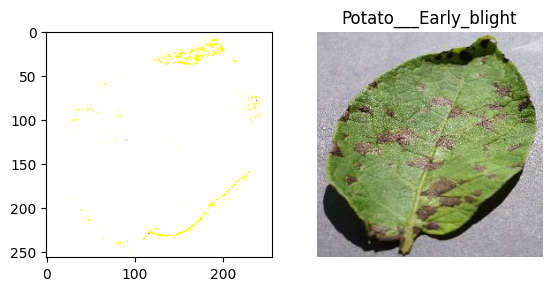

In [11]:
for image_batch, label_batch in dataset.take(1):
    ax = plt.subplot(1,2,1)
    plt.imshow(image_batch[0].numpy())
    ax = plt.subplot(1,2,2)
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

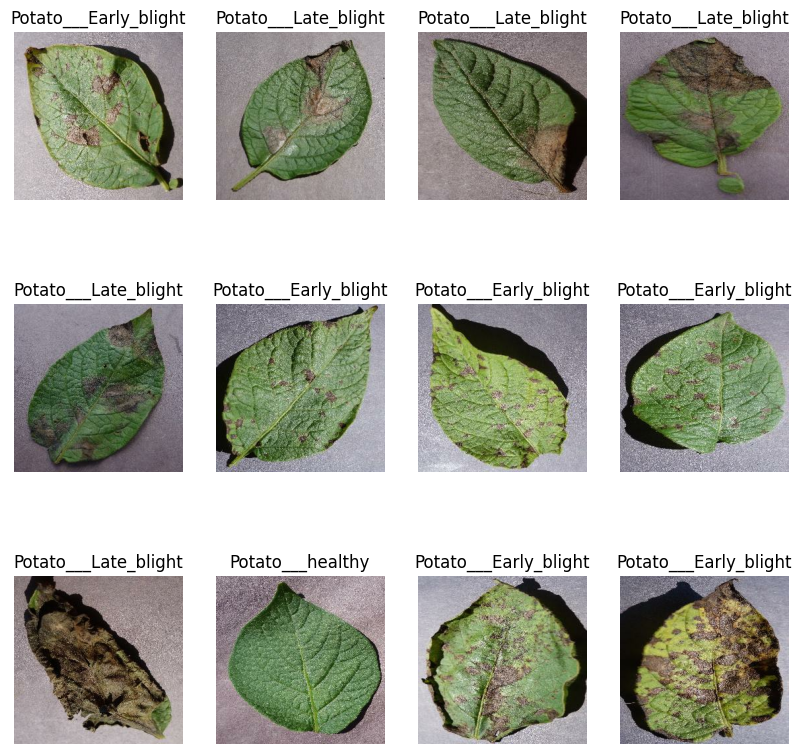

In [12]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [13]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [14]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
train_dataset = dataset.take(54)
len(train_dataset)

54

In [16]:
test_dataset = dataset.skip(54)
len(test_dataset)

14

In [17]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [18]:
validation_dataset = test_dataset.take(6)
len(validation_dataset)

6

In [19]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [22]:
len(train_dataset)

54

In [23]:
len(validation_dataset)

6

In [24]:
len(test_dataset)

8

In [25]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255),
])

In [27]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [28]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 15s 110ms/step - loss: 0.9049 - accuracy: 0.4873 - val_loss: 0.8035 - val_accuracy: 0.5677
Epoch 2/50
54/54 [==============================] - 5s 84ms/step - loss: 0.6868 - accuracy: 0.6545 - val_loss: 0.7406 - val_accuracy: 0.6823
Epoch 3/50
54/54 [==============================] - 4s 80ms/step - loss: 0.4442 - accuracy: 0.7882 - val_loss: 0.5023 - val_accuracy: 0.7396
Epoch 4/50
54/54 [==============================] - 4s 81ms/step - loss: 0.3207 - accuracy: 0.8709 - val_loss: 0.4600 - val_accuracy: 0.7812
Epoch 5/50
54/54 [==============================] - 4s 83ms/step - loss: 0.2627 - accuracy: 0.9074 - val_loss: 0.3513 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 5s 85ms/step - loss: 0.2201 - accuracy: 0.9149 - val_loss: 0.2463 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 5s 90ms/step - loss: 0.1202 - accuracy: 0.9531 - val_loss: 0.1117 - val_accuracy: 0.9531
Epoch 8/50


In [32]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 1s 27ms/step - loss: 7.3975e-05 - accuracy: 1.0000


In [33]:
history

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
history.history['loss']

[0.9048902988433838,
 0.6868128776550293,
 0.4442451000213623,
 0.3206530213356018,
 0.2627243995666504,
 0.2201450616121292,
 0.12018278241157532,
 0.10305183380842209,
 0.06278248876333237,
 0.04491274431347847,
 0.09345103800296783,
 0.022140666842460632,
 0.019192390143871307,
 0.012386302463710308,
 0.015438164584338665,
 0.04097910225391388,
 0.0794619619846344,
 0.01577836647629738,
 0.002826444571837783,
 0.000667543092276901,
 0.00028164577088318765,
 0.00014184246538206935,
 0.00010900077177211642,
 8.909542520996183e-05,
 7.563154213130474e-05,
 6.410608330043033e-05,
 5.658785448758863e-05,
 4.90083584736567e-05,
 4.382508268463425e-05,
 3.9161222957773134e-05,
 3.514601485221647e-05,
 3.1702275009592995e-05,
 2.9078675652272068e-05,
 2.6419071218697354e-05,
 2.445492646074854e-05,
 2.2377425921149552e-05,
 2.040153594862204e-05,
 1.899200287880376e-05,
 1.7575253878021613e-05,
 1.6405621863668784e-05,
 1.5108435036381707e-05,
 1.4119349543761928e-05,
 1.3235850929049775e-0

In [37]:
len(history.history['loss'])

50

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

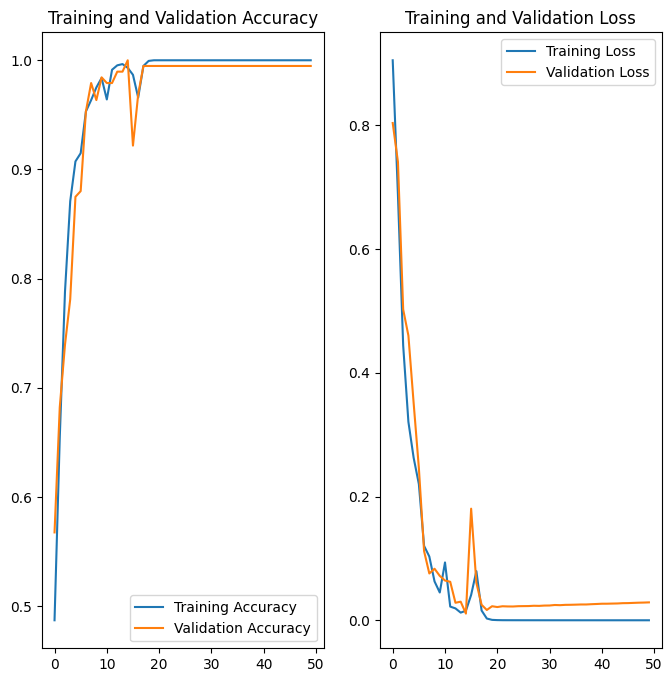

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 143ms/step
predicted label: Potato___Late_blight


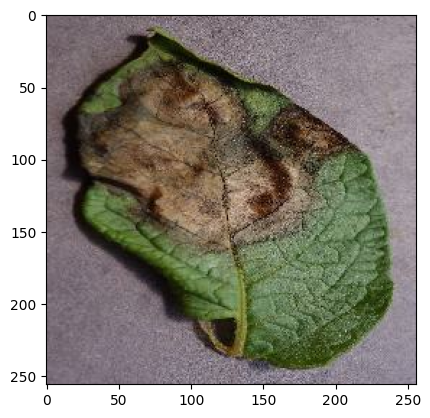

In [40]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


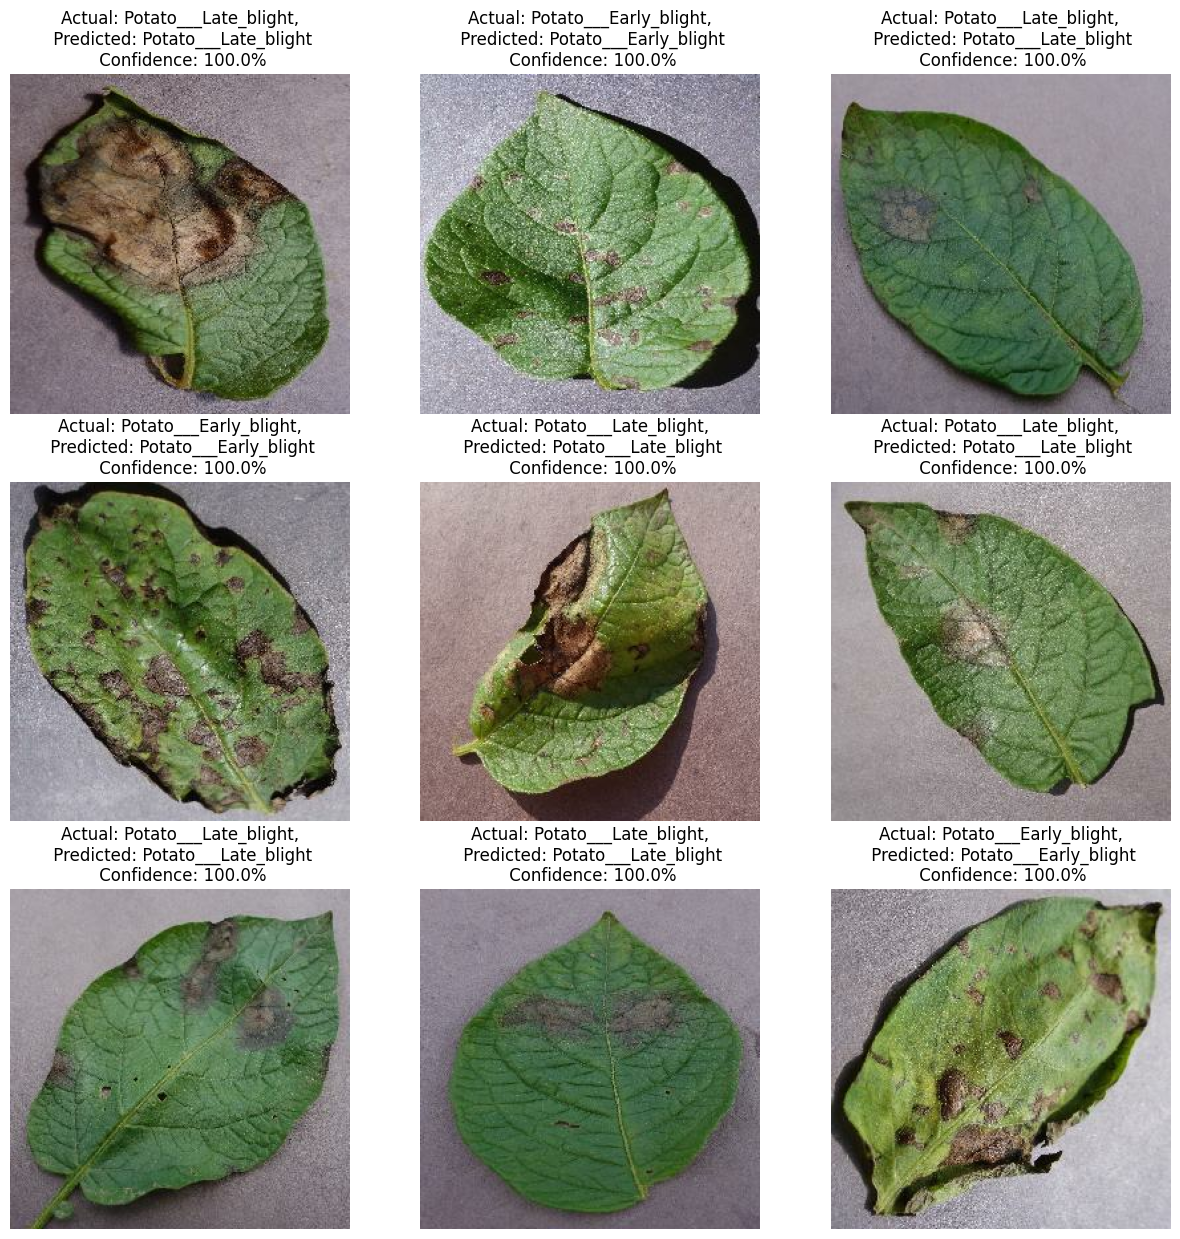

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}\n Confidence: {confidence}%")
        
        plt.axis("off")

In [44]:
model.save("../potatoes.h5")